In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt

#2024-2025 season database
df = pd.read_csv('data/2024_game.csv')
df['Home/Away'] = df['Unnamed: 4'].replace({np.nan: 'Home', '@': 'Away'})
df['Team Points'] = df['PTS']
df['Opponent Points'] = df['PTS.2']
df['Total Points'] = df['Team Points'] + df['Opponent Points']
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(df.head())

   Rk Team        Date  PTS Unnamed: 4  Opp          Result   MP  FG  FGA  \
0   1  CLE  2024-11-15  144        NaN  CHI       W 144-126  240  51   93   
1   2  DEN  2024-10-29  144          @  BRK  W 144-139 (OT)  265  46   89   
2   3  HOU  2024-11-17  143          @  CHI       W 143-107  240  55  105   
3   4  GSW  2024-10-23  140          @  POR       W 140-104  240  48   93   
4   5  SAS  2024-11-13  139        NaN  WAS       W 139-130  240  48   92   

     FG%  2P  2PA    2P%  3P  3PA    3P%  FT  FTA    FT%  PTS.1  FG.1  FGA.1  \
0  0.548  30   50  0.600  21   43  0.488  21   24  0.875    144    45     88   
1  0.517  33   62  0.532  13   27  0.481  39   47  0.830    144    49     96   
2  0.524  45   71  0.634  10   34  0.294  23   32  0.719    143    36    107   
3  0.516  28   45  0.622  20   48  0.417  24   30  0.800    140    36     92   
4  0.522  30   48  0.625  18   44  0.409  25   32  0.781    139    49     95   

   FG%.1  2P.1  2PA.1  2P%.1  3P.1  3PA.1  3P%.1  FT.1  

In [19]:
# Encode team names as integers
team_encoder = LabelEncoder()
df['Team ID'] = team_encoder.fit_transform(df['Team'])
df['Opp ID'] = team_encoder.transform(df['Opp'])

# Verify serialization
print(df[['Team', 'Team ID', 'Opp', 'Opp ID']].head())


  Team  Team ID  Opp  Opp ID
0  CLE        5  CHI       3
1  DEN        7  BRK       2
2  HOU       10  CHI       3
3  GSW        9  POR      24
4  SAS       26  WAS      29


In [20]:
# Aggregate team-level stats by Home and Away
team_stats = df.groupby(['Team', 'Home/Away'])[['Team Points', 'Opponent Points']].mean().reset_index()

# Rename columns for clarity
team_stats.rename(columns={
    'Team Points': 'Avg Points Scored',
    'Opponent Points': 'Avg Points Allowed'
}, inplace=True)

# Verify aggregated stats
print(team_stats.head())


  Team Home/Away  Avg Points Scored  Avg Points Allowed
0  ATL      Away         116.333333          120.666667
1  ATL      Home         116.875000          120.125000
2  BOS      Away         123.750000          110.125000
3  BOS      Home         118.833333          113.166667
4  BRK      Away         109.125000          112.250000


In [21]:
# Add rolling averages for team performance
df['Rolling Avg Points'] = df.groupby('Team')['Team Points'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['Rolling Avg Opp Points'] = df.groupby('Team')['Opponent Points'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())


In [22]:
# Merge aggregated stats for home and away teams
df = df.merge(team_stats, left_on=['Team', 'Home/Away'], right_on=['Team', 'Home/Away'], suffixes=('', '_Home'))
df = df.merge(team_stats, left_on=['Opp', 'Home/Away'], right_on=['Team', 'Home/Away'], suffixes=('_Home', '_Away'))

# Update features
features = ['Team ID', 'Opp ID', 'Avg Points Scored_Home', 'Avg Points Allowed_Home',
            'Avg Points Scored_Away', 'Avg Points Allowed_Away', 'Rolling Avg Points', 'Rolling Avg Opp Points']
X = df[features]
y = df['Total Points']

# Verify features and target
print(X.head())
print(y.head())


   Team ID  Opp ID  Avg Points Scored_Home  Avg Points Allowed_Home  \
0        5       3              124.500000               111.375000   
1        7       2              114.200000               117.800000   
2       10       3              111.833333               107.333333   
3        9      24              125.857143               112.428571   
4       26      29              115.125000               109.625000   

   Avg Points Scored_Away  Avg Points Allowed_Away  Rolling Avg Points  \
0              110.333333               124.166667               144.0   
1              109.125000               112.250000               144.0   
2              119.500000               123.375000               143.0   
3              104.333333               110.666667               140.0   
4              110.833333               124.000000               139.0   

   Rolling Avg Opp Points  
0                   126.0  
1                   139.0  
2                   107.0  
3               

Random Forest RMSE: 9.86, R²: 0.76
XGBoost RMSE: 10.65, R²: 0.72
Linear Regression RMSE: 8.74, R²: 0.81
Tuned XGBoost RMSE: 10.59
Ensemble Model RMSE: 9.27, R²: 0.79


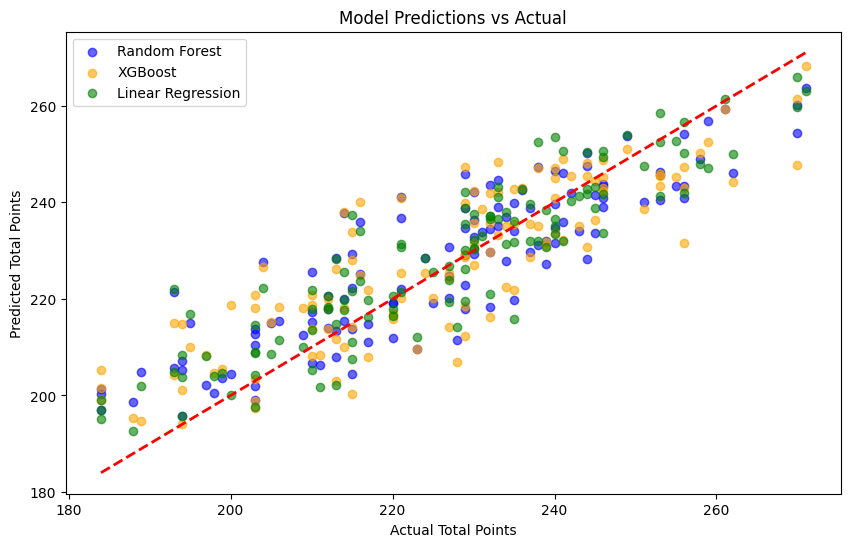

In [37]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest Model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest
rf_rmse = root_mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rf_rmse:.2f}, R²: {rf_r2:.2f}")

# XGBoost Model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost
xgb_rmse = root_mean_squared_error(y_test, y_pred_xgb)
xgb_r2 = r2_score(y_test, y_pred_xgb)
print(f"XGBoost RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.2f}")

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Evaluate Linear Regression
lr_rmse = root_mean_squared_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)
print(f"Linear Regression RMSE: {lr_rmse:.2f}, R²: {lr_r2:.2f}")

# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
}
grid_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, scoring='neg_mean_squared_error', cv=3)
grid_xgb.fit(X_train, y_train)
best_xgb_model = grid_xgb.best_estimator_

# Evaluate tuned XGBoost
y_pred_tuned_xgb = best_xgb_model.predict(X_test)
tuned_xgb_rmse = root_mean_squared_error(y_test, y_pred_tuned_xgb)
print(f"Tuned XGBoost RMSE: {tuned_xgb_rmse:.2f}")

# Ensemble model: Average predictions
y_pred_ensemble = (y_pred_rf + y_pred_xgb + y_pred_lr) / 3

# Evaluate ensemble model
ensemble_rmse = root_mean_squared_error(y_test, y_pred_ensemble)
ensemble_r2 = r2_score(y_test, y_pred_ensemble)
print(f"Ensemble Model RMSE: {ensemble_rmse:.2f}, R²: {ensemble_r2:.2f}")

# Visualize predictions vs actuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, label='Random Forest', color='blue')
plt.scatter(y_test, y_pred_xgb, alpha=0.6, label='XGBoost', color='orange')
plt.scatter(y_test, y_pred_lr, alpha=0.6, label='Linear Regression', color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Total Points')
plt.ylabel('Predicted Total Points')
plt.title('Model Predictions vs Actual')
plt.legend()
plt.show()

#I would have preferred to go further, but the accuracy is really bad. I think the unpredictability + new NBA cup rule may have skew the result a lot. 
# But my ultimate goal here is to showcase what I can do.